<a href="https://colab.research.google.com/github/mysterytony/cs230_project/blob/main/cs230.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title setup


try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

# Install if in Colab
if IN_COLAB:
    %pip install transformer_lens
    %pip install circuitsvis
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs  # noqa
    !pip install git+https://github.com/ashweta1/transformer-utils.git
    # !cd /content && rm -rf /content/home
    !git clone https://github.com/kmeng01/rome home
    !pip install -r /content/home/scripts/colab_reqs/rome.txt
    import os
    os.chdir("/content/home")


from circuitsvis.attention import attention_heads
from fancy_einsum import einsum
from functools import partial
from IPython.display import HTML, IFrame
from jaxtyping import Float
from os import environ
from transformer_lens import ActivationCache, HookedTransformer
from typing import List, Optional, Union
import circuitsvis as cv
import einops
import numpy as np
import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go
import plotly
import torch
import tqdm.auto as tqdm
import transformer_lens
import transformer_lens.utils as utils
import itertools
from transformer_utils.logit_lens import plot_logit_lens
import transformers


Running as a Colab notebook
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency con

In [2]:
#@title Load Model

torch.set_grad_enabled(False)

DEVICE = utils.get_device()
print(f'{DEVICE=}')

PRETRAINED_MODEL = 'gpt2'  # gpt2-small or gpt2-medium
print(f'{PRETRAINED_MODEL=}')

tokenizer = transformers.AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
hf_model = transformers.AutoModelForCausalLM.from_pretrained(PRETRAINED_MODEL)
print("print huggingface model structure", hf_model)
print("model hyper parameters: ", hf_model.config)

transformer_lens_model = transformer_lens.HookedTransformer.from_pretrained(
    PRETRAINED_MODEL, center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    hf_model=hf_model,
    tokenizer=tokenizer,
    refactor_factored_attn_matrices=True, device=DEVICE)

hf_model.to(DEVICE)

print("print transformer lens model structure", transformer_lens_model)

DEVICE=device(type='cpu')
PRETRAINED_MODEL='gpt2'


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

print huggingface model structure GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)
model hyper par

In [3]:
#@title Experiment on tokenization (for math prompts)

prompt = "12+34="

# add space in various places in the prompt
for add_space_indices in itertools.product([True, False], repeat=len(prompt)):
  prompt_with_space = prompt
  for i, bool_add_space in zip(reversed(range(len(prompt))), reversed(add_space_indices)):
    if bool_add_space:
      prompt_with_space = prompt_with_space[:i] + " " + prompt_with_space[i:]
  print(f'\n{prompt_with_space=}')

  utils.test_prompt(prompt=prompt_with_space, answer='579', model=transformer_lens_model, print_details=False)


prompt_with_space=' 1 2 + 3 4 ='


Ranks of the answer tokens: [(' 5', 0), ('79', 7393)]


prompt_with_space=' 1 2 + 3 4='


Ranks of the answer tokens: [(' 5', 0), ('79', 8371)]


prompt_with_space=' 1 2 + 34 ='


Ranks of the answer tokens: [(' 5', 11), ('79', 115)]


prompt_with_space=' 1 2 + 34='


Ranks of the answer tokens: [(' 5', 9), ('79', 226)]


prompt_with_space=' 1 2 +3 4 ='


Ranks of the answer tokens: [(' 5', 1), ('79', 5554)]


prompt_with_space=' 1 2 +3 4='


Ranks of the answer tokens: [(' 5', 6), ('79', 7607)]


prompt_with_space=' 1 2 +34 ='


Ranks of the answer tokens: [(' 5', 9), ('79', 73)]


prompt_with_space=' 1 2 +34='


Ranks of the answer tokens: [(' 5', 16), ('79', 150)]


prompt_with_space=' 1 2+ 3 4 ='


Ranks of the answer tokens: [(' 5', 1), ('79', 7582)]


prompt_with_space=' 1 2+ 3 4='


Ranks of the answer tokens: [(' 5', 0), ('79', 11611)]


prompt_with_space=' 1 2+ 34 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 260)]


prompt_with_space=' 1 2+ 34='


Ranks of the answer tokens: [(' 5', 24), ('79', 391)]


prompt_with_space=' 1 2+3 4 ='


Ranks of the answer tokens: [(' 5', 0), ('79', 7843)]


prompt_with_space=' 1 2+3 4='


Ranks of the answer tokens: [(' 5', 14), ('79', 12431)]


prompt_with_space=' 1 2+34 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 165)]


prompt_with_space=' 1 2+34='


Ranks of the answer tokens: [(' 5', 75), ('79', 284)]


prompt_with_space=' 12 + 3 4 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 313)]


prompt_with_space=' 12 + 3 4='


Ranks of the answer tokens: [(' 5', 5), ('79', 653)]


prompt_with_space=' 12 + 34 ='


Ranks of the answer tokens: [(' 5', 8), ('79', 63)]


prompt_with_space=' 12 + 34='


Ranks of the answer tokens: [(' 5', 11), ('79', 119)]


prompt_with_space=' 12 +3 4 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 332)]


prompt_with_space=' 12 +3 4='


Ranks of the answer tokens: [(' 5', 14), ('79', 569)]


prompt_with_space=' 12 +34 ='


Ranks of the answer tokens: [(' 5', 8), ('79', 37)]


prompt_with_space=' 12 +34='


Ranks of the answer tokens: [(' 5', 25), ('79', 69)]


prompt_with_space=' 12+ 3 4 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 960)]


prompt_with_space=' 12+ 3 4='


Ranks of the answer tokens: [(' 5', 14), ('79', 1833)]


prompt_with_space=' 12+ 34 ='


Ranks of the answer tokens: [(' 5', 8), ('79', 131)]


prompt_with_space=' 12+ 34='


Ranks of the answer tokens: [(' 5', 40), ('79', 210)]


prompt_with_space=' 12+3 4 ='


Ranks of the answer tokens: [(' 5', 5), ('79', 872)]


prompt_with_space=' 12+3 4='


Ranks of the answer tokens: [(' 5', 24), ('79', 1404)]


prompt_with_space=' 12+34 ='


Ranks of the answer tokens: [(' 5', 9), ('79', 94)]


prompt_with_space=' 12+34='


Ranks of the answer tokens: [(' 5', 68), ('79', 140)]


prompt_with_space='1 2 + 3 4 ='


Ranks of the answer tokens: [(' 5', 1), ('79', 6117)]


prompt_with_space='1 2 + 3 4='


Ranks of the answer tokens: [(' 5', 0), ('79', 6515)]


prompt_with_space='1 2 + 34 ='


Ranks of the answer tokens: [(' 5', 12), ('79', 102)]


prompt_with_space='1 2 + 34='


Ranks of the answer tokens: [(' 5', 9), ('79', 194)]


prompt_with_space='1 2 +3 4 ='


Ranks of the answer tokens: [(' 5', 2), ('79', 4498)]


prompt_with_space='1 2 +3 4='


Ranks of the answer tokens: [(' 5', 10), ('79', 4870)]


prompt_with_space='1 2 +34 ='


Ranks of the answer tokens: [(' 5', 9), ('79', 72)]


prompt_with_space='1 2 +34='


Ranks of the answer tokens: [(' 5', 21), ('79', 132)]


prompt_with_space='1 2+ 3 4 ='


Ranks of the answer tokens: [(' 5', 0), ('79', 8869)]


prompt_with_space='1 2+ 3 4='


Ranks of the answer tokens: [(' 5', 1), ('79', 12214)]


prompt_with_space='1 2+ 34 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 321)]


prompt_with_space='1 2+ 34='


Ranks of the answer tokens: [(' 5', 25), ('79', 456)]


prompt_with_space='1 2+3 4 ='


Ranks of the answer tokens: [(' 5', 2), ('79', 9161)]


prompt_with_space='1 2+3 4='


Ranks of the answer tokens: [(' 5', 20), ('79', 12458)]


prompt_with_space='1 2+34 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 185)]


prompt_with_space='1 2+34='


Ranks of the answer tokens: [(' 5', 81), ('79', 298)]


prompt_with_space='12 + 3 4 ='


Ranks of the answer tokens: [(' 5', 7), ('79', 330)]


prompt_with_space='12 + 3 4='


Ranks of the answer tokens: [(' 5', 7), ('79', 613)]


prompt_with_space='12 + 34 ='


Ranks of the answer tokens: [(' 5', 7), ('79', 77)]


prompt_with_space='12 + 34='


Ranks of the answer tokens: [(' 5', 11), ('79', 116)]


prompt_with_space='12 +3 4 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 449)]


prompt_with_space='12 +3 4='


Ranks of the answer tokens: [(' 5', 14), ('79', 666)]


prompt_with_space='12 +34 ='


Ranks of the answer tokens: [(' 5', 9), ('79', 46)]


prompt_with_space='12 +34='


Ranks of the answer tokens: [(' 5', 23), ('79', 63)]


prompt_with_space='12+ 3 4 ='


Ranks of the answer tokens: [(' 5', 5), ('79', 978)]


prompt_with_space='12+ 3 4='


Ranks of the answer tokens: [(' 5', 18), ('79', 1642)]


prompt_with_space='12+ 34 ='


Ranks of the answer tokens: [(' 5', 8), ('79', 145)]


prompt_with_space='12+ 34='


Ranks of the answer tokens: [(' 5', 51), ('79', 196)]


prompt_with_space='12+3 4 ='


Ranks of the answer tokens: [(' 5', 6), ('79', 970)]


prompt_with_space='12+3 4='


Ranks of the answer tokens: [(' 5', 34), ('79', 1235)]


prompt_with_space='12+34 ='


Ranks of the answer tokens: [(' 5', 11), ('79', 94)]


prompt_with_space='12+34='


Ranks of the answer tokens: [(' 5', 127), ('79', 103)]

top results:

```


Tokenized prompt: ['<|endoftext|>', ' 1', ' 2', ' 3', ' +', ' 45', ' 6', '=']
Tokenized answer: [' 5', '79']
Performance on answer token:
Rank: 2        Logit: 11.92 Prob:  1.28% Token: | 5|
Top 0th token. Logit: 12.34 Prob:  1.94% Token: | 1|
Performance on answer token:
Rank: 309      Logit:  6.43 Prob:  0.03% Token: |79|
Top 0th token. Logit: 12.09 Prob:  9.01% Token: |
|
Ranks of the answer tokens: [(' 5', 2), ('79', 309)]

Tokenized prompt: ['<|endoftext|>', ' 12', ' 3', ' +', ' 4', ' 5', ' 6', '=']
Tokenized answer: [' 5', '79']
Performance on answer token:
Rank: 3        Logit: 11.82 Prob:  2.44% Token: | 5|
Top 0th token. Logit: 12.56 Prob:  5.13% Token: |
|
Performance on answer token:
Rank: 1747     Logit:  4.54 Prob:  0.00% Token: |79|
Top 0th token. Logit: 12.84 Prob:  9.16% Token: |
|
Ranks of the answer tokens: [(' 5', 3), ('79', 1747)]

Tokenized prompt: ['<|endoftext|>', '1', ' 2', ' 3', ' +', ' 45', ' 6', '=']
Tokenized answer: [' 5', '79']
Performance on answer token:
Rank: 3        Logit: 11.91 Prob:  1.23% Token: | 5|
Top 0th token. Logit: 12.24 Prob:  1.71% Token: | 1|
Performance on answer token:
Rank: 283      Logit:  6.63 Prob:  0.04% Token: |79|
Top 0th token. Logit: 12.05 Prob:  8.38% Token: |
|
Ranks of the answer tokens: [(' 5', 3), ('79', 283)]

```



prompt='123+456=579 222+444='
input_tokens=tensor([[10163,    10, 29228,    28, 41734, 27795,    10, 30272,    28]])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


generated:  123+456=579 222+444=539+444=539=539+
prompt='Michael Jordan plays the sport of soccer. Michael Jordan plays the sport of'
input_tokens=tensor([[13256,  8078,  5341,   262,  6332,   286, 11783,    13,  3899,  8078,
          5341,   262,  6332,   286]])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


generated:  Michael Jordan plays the sport of soccer. Michael Jordan plays the sport of basketball.

The NBA
prompt='When did Beyonce start becoming popular?'
input_tokens=tensor([[ 2215,   750, 37361,   344,   923,  5033,  2968,    30]])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


generated:  When did Beyonce start becoming popular?
I was a little bit of a fan of her,


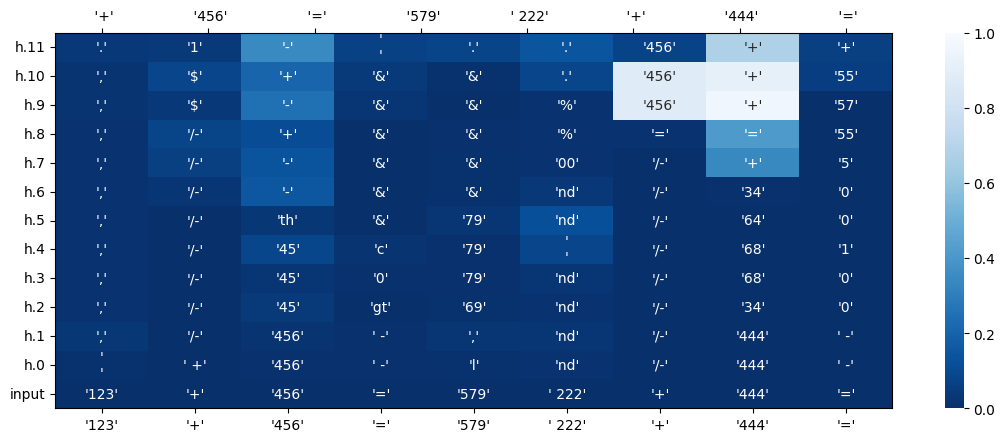

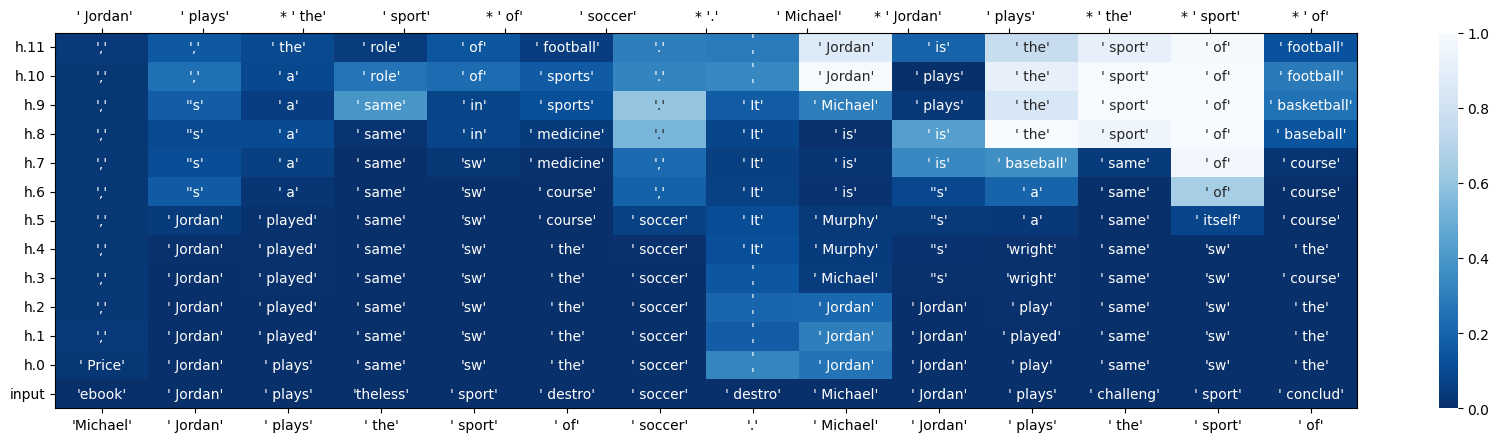

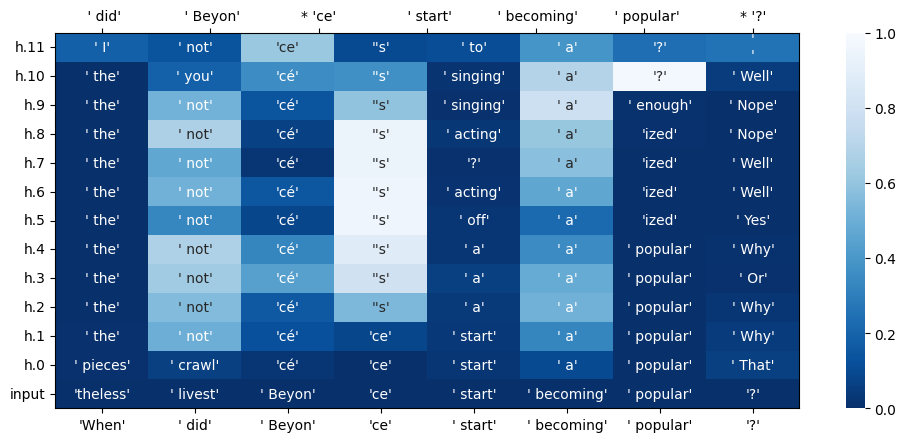

In [41]:
#@title visualize logit lens

prompt_batch = ["123+456=579 222+444=",
                "Michael Jordan plays the sport of soccer. Michael Jordan plays the sport of",
                "When did Beyonce start becoming popular?"]

for prompt in prompt_batch:
  input_tokens = torch.as_tensor(tokenizer.encode(prompt)).view(1, -1).to(DEVICE)
  print(f'{prompt=}')
  print(f'{input_tokens=}')
  plot_logit_lens(hf_model, tokenizer, input_tokens, start_ix=0, end_ix=input_tokens.numel(), probs=True)
  output_tokens = hf_model.generate(input_tokens)
  print('generated: ', tokenizer.decode(output_tokens[0]))

In [5]:
#@title test prompt to get top wrong output tokens

prompt_answer_batch = [
    ("123+456=579 222+444=", "666"),
    ("Michael Jordan plays the sport of soccer. Michael Jordan plays the sport of", "basketball")]

for prompt, answer in prompt_answer_batch:
  utils.test_prompt(prompt=prompt, answer=answer, model=transformer_lens_model)


Tokenized prompt: ['<|endoftext|>', '123', '+', '456', '=', '579', ' 222', '+', '444', '=']
Tokenized answer: [' 666']


Performance on answer token:
Rank: 1915     Logit:  5.77 Prob:  0.00% Token: | 666|

Top 0th token. Logit: 15.38 Prob:  2.77% Token: |8|
Top 1th token. Logit: 15.19 Prob:  2.27% Token: |7|
Top 2th token. Logit: 15.16 Prob:  2.22% Token: |5|
Top 3th token. Logit: 15.16 Prob:  2.20% Token: |6|
Top 4th token. Logit: 14.80 Prob:  1.54% Token: |9|
Top 5th token. Logit: 13.92 Prob:  0.64% Token: |579|
Top 6th token. Logit: 13.87 Prob:  0.61% Token: |559|
Top 7th token. Logit: 13.73 Prob:  0.53% Token: |12|
Top 8th token. Logit: 13.72 Prob:  0.53% Token: |578|
Top 9th token. Logit: 13.70 Prob:  0.51% Token: |585|


Ranks of the answer tokens: [(' 666', 1915)]

Tokenized prompt: ['<|endoftext|>', 'Michael', ' Jordan', ' plays', ' the', ' sport', ' of', ' soccer', '.', ' Michael', ' Jordan', ' plays', ' the', ' sport', ' of']
Tokenized answer: [' basketball']


Performance on answer token:
Rank: 2        Logit: 17.69 Prob:  1.16% Token: | basketball|

Top 0th token. Logit: 22.09 Prob: 94.92% Token: | soccer|
Top 1th token. Logit: 18.23 Prob:  1.99% Token: | football|
Top 2th token. Logit: 17.69 Prob:  1.16% Token: | basketball|
Top 3th token. Logit: 17.21 Prob:  0.72% Token: | baseball|
Top 4th token. Logit: 16.13 Prob:  0.24% Token: | sports|
Top 5th token. Logit: 15.99 Prob:  0.21% Token: | hockey|
Top 6th token. Logit: 15.84 Prob:  0.18% Token: | tennis|
Top 7th token. Logit: 15.70 Prob:  0.16% Token: | Soccer|
Top 8th token. Logit: 15.39 Prob:  0.12% Token: | cricket|
Top 9th token. Logit: 14.53 Prob:  0.05% Token: | rugby|


Ranks of the answer tokens: [(' basketball', 2)]

In [6]:
# @title examine logits from layers

def visualize_logit_layers(input_prompt, right_answers, wrong_answers):
  output_logit, cache = transformer_lens_model.run_with_cache(input_prompt)
  print(f'{input_prompt=}')

  right_answer_tokens = []
  wrong_answer_tokens = []
  for out_token_array, token_strs in [(right_answer_tokens, right_answers), (wrong_answer_tokens, wrong_answers)]:
      for token_str in token_strs:
          print(
              f'|{token_str}| \t token: {transformer_lens_model.to_tokens(token_str, prepend_bos=False)[0][0]} \t logit: {output_logit[0, -1, transformer_lens_model.to_tokens(token_str, prepend_bos=False)[0]]}')
          out_token_array.append(transformer_lens_model.to_tokens(token_str, prepend_bos=False)[0][0])

  accumulated_residual, labels = cache.accumulated_resid(
      layer=-1, incl_mid=True, pos_slice=-1, return_labels=True, apply_ln=True
  )
  accumulated_residual_logits = accumulated_residual @ transformer_lens_model.unembed.W_U + transformer_lens_model.unembed.b_U
  fig = go.Figure()
  for token_str, t in zip(right_answers, right_answer_tokens):
      fig.add_trace(go.Scatter(
          x=np.arange(transformer_lens_model.cfg.n_layers * 2 + 1) / 2,
          y=utils.to_numpy(accumulated_residual_logits[:, 0, t]),
          text=labels,
          name=token_str,
      ))
  for token_str, t in zip(wrong_answers, wrong_answer_tokens):
      fig.add_trace(go.Scatter(
          x=np.arange(transformer_lens_model.cfg.n_layers * 2 + 1) / 2,
          y=utils.to_numpy(accumulated_residual_logits[:, 0, t]),
          text=labels,
          name=token_str,
          line=dict(
              dash='dot',
          )
      ))
  fig.show()

# ['<|endoftext|>', ' 1', ' 2', ' 3', ' +', ' 45', ' 6', '=']
# input_token = " 1 2 3 + 45 6="
# answer_token = " 579"
# right_token_strs = ['5', '57', '579', ' 5', ' 57']
# wrong_token_strs = ['1', ' 1', '12', ' 7']


# ===========
"""
Tokenized prompt: ['<|endoftext|>', 'Michael', ' Jordan', ' plays', ' the', ' sport', ' of']
Tokenized answer: [' basketball']
Performance on answer token:
Rank: 0        Logit: 16.17 Prob: 50.01% Token: | basketball|
Top 0th token. Logit: 16.17 Prob: 50.01% Token: | basketball|
Top 1th token. Logit: 13.77 Prob:  4.53% Token: | football|
Top 2th token. Logit: 13.72 Prob:  4.30% Token: | golf|
Top 3th token. Logit: 13.08 Prob:  2.27% Token: | tennis|
Top 4th token. Logit: 12.90 Prob:  1.90% Token: | soccer|
Top 5th token. Logit: 12.89 Prob:  1.87% Token: | hockey|
Top 6th token. Logit: 12.55 Prob:  1.33% Token: | boxing|
Top 7th token. Logit: 12.38 Prob:  1.13% Token: | sports|
Top 8th token. Logit: 12.24 Prob:  0.98% Token: | the|
Top 9th token. Logit: 12.16 Prob:  0.90% Token: | baseball|
Ranks of the answer tokens: [(' basketball', 0)]
"""

input_prompt_batch = [
    "Michael Jordan plays the sport of soccer. Michael Jordan plays the sport of",
    "Michael Jordan plays the sport of",
    "1 2 3+ 4 5 6="]
right_answer_batch = [[" basketball"], [" basketball"], [" 5", " 57", " 579"]]
wrong_answer_batch = [[' football', 'golf', 'soccer', ' soccer'], [' football', 'golf', ' soccer'], [' 1', '1', ' 7']]

for input_prompt, right_answers, wrong_answers in zip(input_prompt_batch, right_answer_batch, wrong_answer_batch):
  visualize_logit_layers(input_prompt, right_answers, wrong_answers)
# ===========



input_prompt='Michael Jordan plays the sport of soccer. Michael Jordan plays the sport of'
| basketball| 	 token: 9669 	 logit: tensor([17.6896], device='cuda:0')
| football| 	 token: 4346 	 logit: tensor([18.2276], device='cuda:0')
|golf| 	 token: 70 	 logit: tensor([0.9367, 1.2154], device='cuda:0')
|soccer| 	 token: 35634 	 logit: tensor([10.7743,  4.7328], device='cuda:0')
| soccer| 	 token: 11783 	 logit: tensor([22.0942], device='cuda:0')


input_prompt='Michael Jordan plays the sport of'
| basketball| 	 token: 9669 	 logit: tensor([16.1726], device='cuda:0')
| football| 	 token: 4346 	 logit: tensor([13.7722], device='cuda:0')
|golf| 	 token: 70 	 logit: tensor([2.7025e+00, 1.0372e-03], device='cuda:0')
| soccer| 	 token: 11783 	 logit: tensor([12.9006], device='cuda:0')


input_prompt='1 2 3+ 4 5 6='
| 5| 	 token: 642 	 logit: tensor([10.2151], device='cuda:0')
| 57| 	 token: 7632 	 logit: tensor([5.0421], device='cuda:0')
| 579| 	 token: 642 	 logit: tensor([10.2151,  5.8144], device='cuda:0')
| 1| 	 token: 352 	 logit: tensor([10.5365], device='cuda:0')
|1| 	 token: 16 	 logit: tensor([10.8892], device='cuda:0')
| 7| 	 token: 767 	 logit: tensor([10.4582], device='cuda:0')


In [38]:
#@title (wip) fine tuning for math prompts

# from datasets import Dataset
# def gen():

#     yield {"pokemon": "bulbasaur", "type": "grass"}
#     yield {"pokemon": "squirtle", "type": "water"}
# ds = Dataset.from_generator(gen)
# print(ds[0])

from util.globals import DATA_DIR
from dsets import KnownsDataset
from torch.utils.data import DataLoader

knowns_dataset = KnownsDataset(DATA_DIR)
print(len(knowns_dataset))

train_set, val_set = torch.utils.data.random_split(knowns_dataset, [1109, 100])

from torch.optim import AdamW
optimizer = AdamW(hf_model.parameters(), lr=5e-5)

from transformers import get_scheduler

train_dataloader= DataLoader(train_set, shuffle=True, batch_size=8)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)


from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

hf_model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
      print(batch['prompt'])
      batch = torch.as_tensor(tokenizer(batch['prompt'])).to(DEVICE)
      outputs = hf_model(**batch)

      break

        # batch = {k: v.to(DEVICE) for k, v in batch.items()}
        #
        # loss = outputs.loss
        # loss.backward()

        # optimizer.step()
        # lr_scheduler.step()
        # optimizer.zero_grad()
        # progress_bar.update(1)


Loaded dataset with 1209 elements
1209


  0%|          | 0/417 [00:00<?, ?it/s]

['Tim Cook is employed by', 'Melodiya is headquartered in', 'Johnson Glacier belongs to the continent of', 'Hersekzade Ahmed Pasha follows the religion of', 'John XXIII holds the title of "the most popular', 'LeBron James professionally plays the sport of', 'Ylvis was created in the country of their birth,', 'Xbox, created by']


RuntimeError: Could not infer dtype of tokenizers.Encoding

In [46]:
#@title fine tune with squad

from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm
from transformers import get_scheduler

squad_dataset = load_dataset("squad_v2", split='train[:1000]')

def preprocess_function(batch):
  """
  return tokenized prompt
  """
  questions = batch["question"]
  # contexts = batch["context"]
  answers = [a["text"][0] if len(a["text"]) > 0 else "No answer" for a in batch["answers"]]
  # prompt = f"Context: {context}\nQuestion: {question}\nAnswer:"
  input_batch = [f"{q} {a}" for q, a in zip(questions, answers)]
  print(input_batch[0])
  return tokenizer(input_batch, truncation=True, max_length=512, padding="max_length")

tokenized_squad_dataset = squad_dataset.map(preprocess_function, batched=True, remove_columns=squad_dataset.column_names)
tokenized_squad_dataset.set_format("torch")
print(tokenized_squad_dataset[0]['input_ids'].shape)

train_dataloader = DataLoader(tokenized_squad_dataset, shuffle=True, batch_size=8)
optimizer = AdamW(hf_model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

progress_bar = tqdm(range(num_training_steps))

hf_model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # batch = {k: v.to(device) for k, v in batch.items()}
        outputs = hf_model(batch['input_ids'])
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)


torch.Size([512])


  0%|          | 0/375 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
stack_head_result, labels = cache.stack_head_results(
    layer=-1, pos_slice=-1, return_labels=True, apply_ln=True
)
stack_head_result = stack_head_result @ model.unembed.W_U + model.unembed.b_U
stack_head_result = stack_head_result.view(12, 12, -1)

figs = make_subplots(rows=2, cols=5, subplot_titles=right_token_str+wrong_token_str)
i = 1
for token_str, t in zip(right_token_str, right_tokens):
  subfig = px.imshow(
      utils.to_numpy(stack_head_result[:,:, t]),
      labels={"x": "Head", "y": "Layer"},
  )
  for trace in subfig.data:
    figs.add_trace(trace, row=1, col=i)
  i = i + 1

# wrong_token_fig = make_subplots(rows=1, cols=4, subplot_titles=wrong_token_str)
i = 1
for token_str, t in zip(wrong_token_str, wrong_tokens):
  subfig = px.imshow(
      utils.to_numpy(stack_head_result[:,:, t]),
      labels={"x": "Head", "y": "Layer"},
  )
  for trace in subfig.data:
    figs.add_trace(trace, row=2, col=i)
  i = i + 1
figs.show()




NameError: name 'cache' is not defined